In [2]:
!pip install segmentation_models
!wget https://graphicwg.irafm.osu.cz/storage/carvana.zip --no-check-certificate
!unzip carvana.zip

Výstupní stream byl oříznut na posledních 5000 řádků.
  inflating: train_masks/0789bed99cb8_10_mask.png  
  inflating: train_masks/0789bed99cb8_11_mask.png  
  inflating: train_masks/0789bed99cb8_12_mask.png  
  inflating: train_masks/0789bed99cb8_13_mask.png  
  inflating: train_masks/0789bed99cb8_14_mask.png  
  inflating: train_masks/0789bed99cb8_15_mask.png  
  inflating: train_masks/0789bed99cb8_16_mask.png  
  inflating: train_masks/0795e132d090_01_mask.png  
  inflating: train_masks/0795e132d090_02_mask.png  
  inflating: train_masks/0795e132d090_03_mask.png  
  inflating: train_masks/0795e132d090_04_mask.png  
  inflating: train_masks/0795e132d090_05_mask.png  
  inflating: train_masks/0795e132d090_06_mask.png  
  inflating: train_masks/0795e132d090_07_mask.png  
  inflating: train_masks/0795e132d090_08_mask.png  
  inflating: train_masks/0795e132d090_09_mask.png  
  inflating: train_masks/0795e132d090_10_mask.png  
  inflating: train_masks/0795e132d090_11_mask.png  
  inflatin

In [72]:
%env SM_FRAMEWORK = tf.keras

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from glob import glob
import random
import albumentations as A
from tensorflow.keras.callbacks import ReduceLROnPlateau
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras


In [4]:
BATCH_SIZE=8

In [5]:
model = sm.Unet('resnet18', classes=2, input_shape=(320, 480, 3), encoder_weights=None)
model.compile('Adam', sm.losses.DiceLoss())

In [6]:
def load_data(path_imgs, path_labs):
    imgs = []
    labs = []
    for file in sorted(glob(path_imgs+'/*.*')): 
        im  = cv.imread(file)
        lab = cv.imread(file.replace('.jpg', '_mask.png').replace(path_imgs, path_labs),0)
        

        imgs.append(cv.cvtColor(im, cv.COLOR_BGR2RGB))
        labs.append(lab)
    return np.asarray(imgs), np.asarray(labs)
    
x_train, y_train = load_data('train', 'train_masks')    
x_valid, y_valid = load_data('valid', 'valid_masks')    
                          
print('train:', x_train.shape, y_train.shape)
print('valid:', x_valid.shape, y_valid.shape)

train: (4888, 320, 480, 3) (4888, 320, 480)
valid: (200, 320, 480, 3) (200, 320, 480)


In [32]:
def augment(img, img2):
  t = A.Compose([
                  A.OneOf([
                    #ToRandomValues
                    A.RandomBrightness(limit=.2, always_apply=False, p=.5),
                    A.RandomGamma(gamma_limit=(60, 140), always_apply=False, p=.5),
                    A.RandomContrast(limit=.2, always_apply=False, p=.5),
                  ], p=0.5)
  ]
  )
  aug = t(image=img, mask=img2)
  image = aug["image"].copy()
  image = cv.cvtColor(image, cv.COLOR_RGB2HSV)
  h_change = random.randrange(0, 179)
  image[...,0] = (image[...,0]+h_change)%179
  image = cv.cvtColor(image, cv.COLOR_HSV2RGB)
  mask = aug["mask"]
  tmp = aug["image"].copy()
  tmp[mask[...,0]==0]=image[mask[...,0]==0]

  return tmp, mask

In [33]:
#vlastni generator dat s wrappery
def data_generator(is_train):
    while True:
        g_images = []
        g_labels = []
        for b in range(BATCH_SIZE):
            if(is_train == True):
              index = random.randrange(0, len(x_train))
              g_im, g_la = x_train[index], y_train[index]
              g_im, g_la = augment(g_im, g_la)
            if(is_train == False):
              index = random.randrange(0, len(x_valid))
              g_im, g_la = x_valid[index], y_valid[index]
            mask = np.zeros((g_la.shape[0], g_la.shape[1], 2))
            mask[...,0] = g_la==0
            mask[...,1] = g_la==255
            g_images.append(g_im)
            g_labels.append(mask)
        g_images = np.asarray(g_images)
        g_labels = np.asarray(g_labels)

        yield g_images.astype('float'), g_labels.astype('float')

def data_generator_wrapper_train():
    return data_generator(True)

def data_generator_wrapper_valid():
    return data_generator(False)

In [68]:
a = data_generator(True)
x, y = next(a)
print (x.shape)
print (y.shape)

(8, 320, 480, 3)
(8, 320, 480, 2)


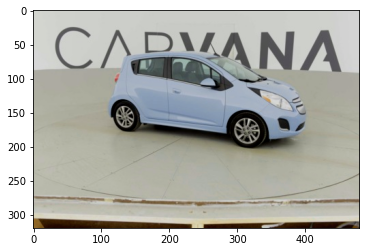

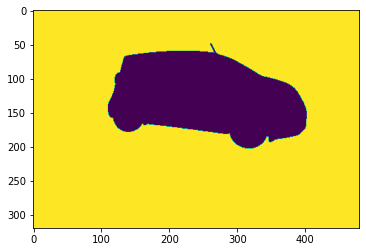

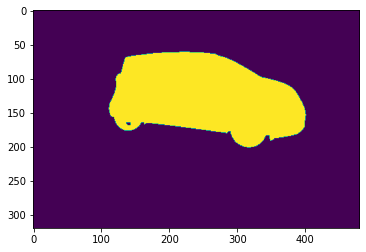

In [69]:
plt.imshow(x[0,...].astype(int))
plt.show()
plt.imshow(y[0,...,0].astype(int))
plt.show()
plt.imshow(y[0,...,1].astype(int))
plt.show()

In [73]:
#totok dame uceni site
lro = ReduceLROnPlateau(patience=1, verbose=1)
model.fit(data_generator_wrapper_train(),
          batch_size=BATCH_SIZE,
          validation_data=data_generator_wrapper_valid(),
          steps_per_epoch=len(x_train)//BATCH_SIZE,
          validation_steps=len(x_valid)//BATCH_SIZE,
          epochs=3,
          callbacks=[lro])

Epoch 1/3
611/611 [==============================] - 380s 622ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 2/3
611/611 [==============================] - 382s 625ms/step - loss: 0.0056 - val_loss: 0.0066

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/3
611/611 [==============================] - 380s 621ms/step - loss: 0.0047 - val_loss: 0.0062

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
